In [4]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Normalizer, MinMaxScaler, RobustScaler
from nltk.stem.porter import PorterStemmer


# conda install -c conda-forge lightgbm 
#import lightgbm as lgb

In [5]:
#porter_stemmer = PorterStemmer()

In [6]:
#porter_stemmer.stem("Fishes")

The following code will help to throw away all HTML tags from article content/title.

In [7]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [8]:
PATH_TO_DATA = './data'

Supplementary function to read a JSON line without crashing on escape characters.

In [9]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

This function takes a JSON and forms a txt file leaving only article titles. When you resort to feature engineering and extract various features from articles, a good idea is to modify this function.

#### Fields available in the json_data:

```js
['_id', '_timestamp', '_spider', 'url', 'domain', 'published',
 'title', 'content', 'author', 'image_url', 'tags', 'link_tags', 'meta_tags']
```

### Extract domain

In [10]:
def extract_domain_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            domain = json_data['domain'].replace('\n', ' ').replace('\r', ' ')
            out_file.write(domain + '\n')

In [11]:
%%time
extract_domain_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_domain.txt', total_length=62313)


CPU times: user 12.4 s, sys: 634 ms, total: 13.1 s
Wall time: 13.1 s


In [12]:
%%time
extract_domain_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_domain.txt', total_length=34645)


CPU times: user 7.02 s, sys: 416 ms, total: 7.44 s
Wall time: 7.43 s


### Extract tags

In [13]:
def extract_tags_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            tags = json_data['tags']#.replace('\n', ' ').replace('\r', ' ')
            #tags = json_data['tags'].replace('\n', ' ').replace('\r', ' ')
            #print(json_data['image_url'])
            #tags = ' '.join(json_data['tags'])
            tags = len(json_data['tags'])
            out_file.write(str(tags) + '\n')

In [14]:
%%time
extract_tags_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_tags.txt', total_length=62313)


CPU times: user 12.5 s, sys: 619 ms, total: 13.1 s
Wall time: 13.1 s


### Extract image_url

In [15]:
def extract_image_url_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            #tags = json_data['tags'].replace('\n', ' ').replace('\r', ' ')
            #print(json_data['image_url'])
            if json_data['image_url'] != None:
                image_url = '1'
                #image_url = json_data['image_url'].replace('\n', ' ').replace('\r', ' ')
            else:
                image_url = '0'
            out_file.write(image_url + '\n')

In [16]:
%%time
extract_image_url_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_image_url.txt', total_length=62313)


CPU times: user 12.4 s, sys: 617 ms, total: 13 s
Wall time: 13 s


In [17]:
%%time
extract_image_url_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_image_url.txt', total_length=34645)


CPU times: user 6.93 s, sys: 324 ms, total: 7.26 s
Wall time: 7.24 s


### Extract content

In [23]:
porter_stemmer = PorterStemmer()

def remove_punctuation(text):
    
    # Tokenize the string into words
    #tokens = word_tokenize(text)
    tokens = text.split()

    # Remove non-alphabetic tokens, such as punctuation
    words = [word.lower() for word in tokens if word.isalpha()]
    words = [porter_stemmer.stem(word) for word in words]
    
    return ' '.join(words)

In [24]:
def extract_content_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = remove_punctuation(strip_tags(content))
            out_file.write(content_no_html_tags + '\n')

In [25]:
%%time
extract_content_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_content.txt', total_length=62313)


CPU times: user 21min 31s, sys: 5.76 s, total: 21min 36s
Wall time: 21min 35s


In [26]:
%%time
extract_content_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_content.txt', total_length=34645)


CPU times: user 11min 27s, sys: 3.22 s, total: 11min 30s
Wall time: 11min 30s


### Extract titles

In [27]:
def extract_titles_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            content = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            #content_no_html_tags = remove_punctuation(strip_tags(content))
            #content_no_html_tags = remove_punctuation(strip_tags(content))
            #out_file.write(content_no_html_tags + '\n')
            out_file.write(content + '\n')

In [28]:
%%time
extract_titles_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_titles.txt', total_length=62313)


CPU times: user 12.5 s, sys: 638 ms, total: 13.1 s
Wall time: 13.1 s


In [29]:
%%time
extract_titles_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_titles.txt', total_length=34645)


CPU times: user 6.98 s, sys: 331 ms, total: 7.31 s
Wall time: 7.3 s


In [30]:
#!head -5 ./train_titles.txt

### Extract authors

In [31]:
def extract_authors_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            # {'name': None, 'url': 'https://medium.com/@Medium', 'twitter': '@Medium'}
            authors = json_data['author']['url'].replace('\n', ' ').replace('\r', ' ')
            out_file.write(authors + '\n')

In [32]:
%%time
extract_authors_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_authors.txt', total_length=62313)


CPU times: user 12.4 s, sys: 636 ms, total: 13.1 s
Wall time: 13 s


In [33]:
%%time
extract_authors_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_authors.txt', total_length=34645)


CPU times: user 7.01 s, sys: 340 ms, total: 7.35 s
Wall time: 7.34 s


### Extract Published

In [34]:
def extract_published_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            # {'$date': '2015-08-03T07:44:50.331Z'}
            published = json_data['published']['$date'].replace('\n', ' ').replace('\r', ' ')
            out_file.write(published + '\n')

In [35]:
%%time
extract_published_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_published.txt', total_length=62313)


CPU times: user 12.5 s, sys: 666 ms, total: 13.2 s
Wall time: 13.2 s


In [36]:
%%time
extract_published_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_published.txt', total_length=34645)


CPU times: user 6.97 s, sys: 330 ms, total: 7.3 s
Wall time: 7.28 s


## Add features

### Add Content features

In [100]:
#stop_words="english"
#tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1, 2), analyzer="word", stop_words="english")
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 3))
# old with 1,2 3 min 7s

In [101]:
%%time
with open('./train_content.txt') as input_train_file:
    X_train_content_sparse = tfidf.fit_transform(input_train_file)

CPU times: user 8min 35s, sys: 1min 38s, total: 10min 14s
Wall time: 11min 5s


In [102]:
%%time
#with open('./test_content.txt', encoding='utf-8') as input_train_file:
with open('./test_content.txt') as input_train_file:
    X_test_content_sparse = tfidf.transform(input_train_file)

CPU times: user 1min 20s, sys: 923 ms, total: 1min 21s
Wall time: 1min 21s


Add content length feature

In [40]:
%%time
train_content_df = pd.read_csv('./train_content.txt', header=None, names=['content'])

CPU times: user 3.5 s, sys: 331 ms, total: 3.83 s
Wall time: 3.83 s


In [41]:
%%time
test_content_df = pd.read_csv('./test_content.txt', header=None, names=['content'])

CPU times: user 1.82 s, sys: 160 ms, total: 1.98 s
Wall time: 1.97 s


In [42]:
def do_content_length(df):
    foo = pd.DataFrame(index=df.index)
    foo['content_length'] = df['content'].apply(lambda x: len(x)).astype('float64')
    
    foo['content_length'] = RobustScaler().fit_transform(foo['content_length'].values.reshape(-1, 1))

    #foo['content_length'] = StandardScaler().fit_transform(foo['content_length'].values.reshape(-1, 1))
    #return foo
    return csr_matrix(foo.values)

In [43]:
X_train_content_length_sparse = do_content_length(train_content_df)

In [44]:
X_test_content_length_sparse = do_content_length(test_content_df)

### Add title features
We'll use a very simple feature extractor – TfidfVectorizer, meaning that we resort to the Bag-of-Words approach. For now, we are leaving only 50k features.

In [45]:
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1, 2))

In [46]:
%%time
with open('train_titles.txt', encoding='utf-8') as input_train_file:
    X_train_title_sparse = tfidf.fit_transform(input_train_file)

CPU times: user 2.74 s, sys: 119 ms, total: 2.86 s
Wall time: 2.07 s


In [47]:
%%time
with open('test_titles.txt', encoding='utf-8') as input_test_file:
    X_test_title_sparse = tfidf.transform(input_test_file)

CPU times: user 1.19 s, sys: 44.3 ms, total: 1.24 s
Wall time: 590 ms


In [48]:
X_train_title_sparse.shape, X_test_title_sparse.shape

((62313, 100000), (34645, 100000))

Read targets from a file

In [49]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                        'train_log1p_recommends.csv'), 
                           index_col='id')

In [50]:
y_train = train_target['log_recommends'].values

Target is still somewhat skewed, though it's allready log1p-transformed (#claps with log1p transformation). Yet, we'll apply log1p once more time.

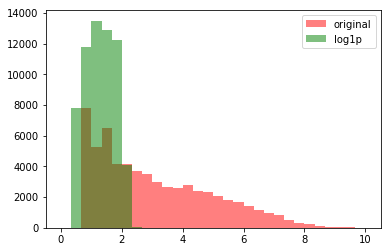

In [51]:
plt.hist(y_train, bins=30, alpha=.5, color='red', 
         label='original', range=(0,10));
plt.hist(np.log1p(y_train), bins=30, alpha=.5, color='green', 
         label='log1p', range=(0,10));
plt.legend();

### Add author feature

In [52]:
train_author_df = pd.read_csv('./train_authors.txt', header=None, names=['author'])
train_author_df.head(3)

,author
0,https://medium.com/@Medium
1,https://medium.com/@Medium
2,https://medium.com/@aelcenganda


In [53]:
test_author_df = pd.read_csv('./test_authors.txt', header=None, names=['author'])
test_author_df.head(3)

,author
0,https://medium.com/@HITRECORD.org
1,https://medium.com/@mariabustillos
2,https://medium.com/@HITRECORD.org


Create a united dataframe of author data for one hot encoding the author data

In [54]:
## United dataframe of the author data 
#full_author_df = pd.concat([train_author_df, test_author_df])

## Index to split the training and test data sets
#idx_split = train_author_df.shape[0]

In [55]:
#onehotencoder = OneHotEncoder(categories='auto')
#X_full_author_sparse = onehotencoder.fit_transform(full_author_df).toarray()

In [56]:
#X_full_author_sparse.shape

Split the authors back into training and test sets 

In [57]:
#X_train_author_sparse = X_full_author_sparse[:idx_split,:]

In [58]:
#X_test_author_sparse = X_full_author_sparse[idx_split:,:]

In [59]:
#print(X_train_author_sparse.shape)
#print(X_test_author_sparse.shape)

In [60]:
author_onehotencoder = OneHotEncoder(categories='auto', handle_unknown="ignore")

In [61]:
X_train_author_sparse = author_onehotencoder.fit_transform(train_author_df).toarray()

In [62]:
X_train_author_sparse.shape

(62313, 32182)

In [63]:
X_test_author_sparse = author_onehotencoder.transform(test_author_df).toarray()

In [64]:
X_test_author_sparse.shape

(34645, 32182)

### Add date time features

In [65]:
train_published_df = pd.read_csv('./train_published.txt',
                           header=None, names=['published'], parse_dates=['published'])
test_published_df = pd.read_csv('./test_published.txt',
                           header=None, names=['published'], parse_dates=['published'])

In [66]:
def add_time_features(df):    
    hour = df['published'].apply(lambda ts: ts.hour)
    
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    
    dayofweek = df['published'].apply(lambda ts: ts.dayofweek)
    is_weekday = ((dayofweek == 5) | (dayofweek == 6)).astype('int')

    onehotencoder = OneHotEncoder(categories='auto')
    #dayofweek_hot_encoded = onehotencoder.fit_transform(dayofweek.values.reshape(-1, 1)).toarray()
    
    #onehotencoder = OneHotEncoder(categories='auto')
    #hour_published_hot_encoded = onehotencoder.fit_transform(hour.values.reshape(-1, 1)).toarray()

    #month_published = df['published'].apply(lambda ts: ts.month).astype('int')
    #onehotencoder = OneHotEncoder(categories='auto')
    #month_published_hot_encoded = onehotencoder.fit_transform(month_published.values.reshape(-1, 1)).toarray()

    
    empty_sparse_matrix = csr_matrix((df.shape[0], 0))
    X = hstack([empty_sparse_matrix,
                morning.values.reshape(-1, 1),
                day.values.reshape(-1, 1),
                evening.values.reshape(-1, 1),
                night.values.reshape(-1, 1),
                #dayofweek_hot_encoded,
                is_weekday.values.reshape(-1,1),
                #month_published_hot_encoded # #ignore for now - the test set does not have data for all 12 months
                #hour_published_hot_encoded  
                ]).tocsr()
    return X

In [67]:
%%time
X_train_time_features_sparse = add_time_features(train_published_df)

CPU times: user 363 ms, sys: 4.13 ms, total: 367 ms
Wall time: 366 ms


In [68]:
%%time
X_test_time_features_sparse = add_time_features(test_published_df)

CPU times: user 213 ms, sys: 1.48 ms, total: 215 ms
Wall time: 214 ms


### Add image_url feature

In [69]:
train_image_url_df = pd.read_csv('./train_image_url.txt', header=None, names=['image_url'])
train_image_url_df.head(3)

,image_url
0,0
1,0
2,1


In [70]:
test_image_url_df = pd.read_csv('./test_image_url.txt', header=None, names=['image_url'])
test_image_url_df.head(3)

,image_url
0,1
1,1
2,1


In [71]:
X_train_image_url_sparse = csr_matrix(train_image_url_df.values)

In [72]:
X_test_image_url_sparse = csr_matrix(test_image_url_df.values)

### Add domain feature

In [73]:
train_domain_df = pd.read_csv('./train_domain.txt', header=None, names=['train_domain'])
#train_domain_df.head(15)

In [74]:
test_domain_df = pd.read_csv('./test_domain.txt', header=None, names=['train_domain'])

In [75]:
def is_site(x, l):
    if x in l:
      return 1
    return 0


def add_domain_feature(df):    
    foo = pd.DataFrame(index=df.index)
    foo['is_medium'] = df['train_domain'].apply(lambda x: is_site('medium.com', x))
    foo['is_hackernoon'] = df['train_domain'].apply(lambda x: is_site('hackernoon.com', x))
    return csr_matrix(foo.values)

In [76]:
X_train_domain_sparse = add_domain_feature(train_domain_df)

In [77]:
X_train_domain_sparse.shape

(62313, 2)

In [78]:
X_test_domain_sparse = add_domain_feature(test_domain_df)

In [79]:
X_test_domain_sparse.shape

(34645, 2)

### Join all sparse matrices

In [103]:
%%time
X_train = hstack([X_train_author_sparse,
                  X_train_time_features_sparse,
                  X_train_title_sparse,
                  X_train_content_sparse,
                  #X_train_content_length_sparse,  # bad feature, do not use
                  X_train_image_url_sparse,
                  X_train_domain_sparse
                ]).tocsr()

CPU times: user 26.4 s, sys: 15.9 s, total: 42.3 s
Wall time: 40.7 s


In [104]:
%%time
X_test = hstack([X_test_author_sparse,
                 X_test_time_features_sparse,
                 X_test_title_sparse,
                 X_test_content_sparse,
                 #X_test_content_length_sparse,
                 X_test_image_url_sparse,
                 X_test_domain_sparse
                ]).tocsr()

CPU times: user 12.8 s, sys: 5.7 s, total: 18.5 s
Wall time: 15.3 s


In [105]:
print(X_train.shape)
print(X_test.shape)

(62313, 182190)
(34645, 182190)


## Validation and model training
Let's make a 30%-holdout set.

In [106]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

Now we are ready to fit a linear model.

In [168]:
ridge = Ridge(random_state=17, alpha=1.5)

In [169]:
%%time
ridge.fit(X_train_part, np.log1p(y_train_part));

CPU times: user 21 s, sys: 399 ms, total: 21.4 s
Wall time: 20.1 s


Ridge(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

After log1p-transformation, we need to apply an inverse  expm1-transformation to predictions.

In [170]:
ridge_pred = np.expm1(ridge.predict(X_valid))

In [171]:
ridge_valid_mae = mean_absolute_error(y_valid, ridge_pred)
ridge_valid_mae # 1.071047542156736  # idf at 2 ngrams

1.0674985930216354

In [ ]:
# alpha 2.0
#1.0674985930216354   alpha 1.5

In [111]:
ridge_valid_mae = mean_absolute_error(y_valid, ridge_pred)
ridge_valid_mae # 1.1234780117087335   # 1.0642772598253594  # with content included

1.0690509257346499

Then, we fit a LightGBM model with mean_absolute_error as objective (it's important!).

In [112]:
# lgb_x_train_part = lgb.Dataset(X_train_part.astype(np.float32), label=np.log1p(y_train_part))

In [113]:
# lgb_x_valid = lgb.Dataset(X_valid.astype(np.float32), label=np.log1p(y_valid))

In [114]:
#param = {'num_leaves': 255, 
#         'objective': 'mean_absolute_error',
#         'metric': 'mae'}

In [115]:
# num_round = 200
# bst_lgb = lgb.train(param, lgb_x_train_part, num_round, valid_sets=[lgb_x_valid], early_stopping_rounds=20)

In [116]:
# lgb_pred = np.expm1(bst_lgb.predict(X_valid.astype(np.float32), num_iteration=bst_lgb.best_iteration))

Let's plot predictions and targets for the holdout set. Recall that these are #recommendations (= #claps) of Medium articles with the  np.log1p transformation.

In [117]:
#plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
#plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
#plt.hist(lgb_pred, bins=30, alpha=.5, color='blue', label='Lgbm', range=(0,10));
#plt.legend();

As we can see, the prediction is far from perfect, and we get MAE  ≈  1.3 that corresponds to  ≈  2.7 error in #recommendations.

In [118]:
ridge_valid_mae = mean_absolute_error(y_valid, ridge_pred)
ridge_valid_mae # 1.0697896558133226

1.0690509257346499

In [119]:
# lgb_valid_mae = mean_absolute_error(y_valid, lgb_pred)
# lgb_valid_mae

## Simple blending
Now let's mix predictions. We's just pick up weights 0.6 for Lgbm and 0.4 for Ridge, but these are typically tuned via cross-validation.

In [120]:
# mean_absolute_error(y_valid, .4 * lgb_pred + .6 * ridge_pred)

Finally, train both models on the full accessible training set, make predictions for the test set and form submission files.

In [121]:
%%time
ridge.fit(X_train, np.log1p(y_train));

CPU times: user 29 s, sys: 549 ms, total: 29.6 s
Wall time: 28.2 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [122]:
%%time
ridge_test_pred = np.expm1(ridge.predict(X_test))

CPU times: user 58.9 ms, sys: 1.4 ms, total: 60.3 ms
Wall time: 59.2 ms


In [123]:
#lgb_x_train = lgb.Dataset(X_train.astype(np.float32), label=np.log1p(y_train))

In [124]:
#num_round = 60
#bst_lgb = lgb.train(param, lgb_x_train, num_round)

In [125]:
#lgb_test_pred = np.expm1(bst_lgb.predict(X_test.astype(np.float32)))

Here's a simple mix

In [126]:
# mix_pred = .4 * lgb_test_pred + .6 * ridge_test_pred

### Leaderboard probing
Now we apply a dirty hack. Originally, we made you come up with it by your own (as a part of an assignment, with only a hint from out side), but now it's described in this tutorial, written within a previous session of mlcourse.ai.

Submitting all zeros gives 4.33328. If you take a pen and a piece of paper and figure out what it means for MAE that all predictions are zeros, then you'll see that it's exactly the mean target value for the test set. We can compare it with mean target for training data and correspondingly adjust predictions. Looks like a dirty hack, however, the same thing is often done with time series prediction (even in production) - merely adjusting your predictions to a change in target variable distribution.

In [127]:
mean_test_target = 4.33328

In [128]:
# mix_test_pred_modif = mix_pred + mean_test_target - y_train.mean()
#mix_test_pred_modif = ridge_test_pred + mean_test_target - y_train.mean()

In [129]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [130]:
# 1.46107
write_submission_file(ridge_test_pred + mean_test_target - y_train.mean(), 'submissions/11-ridge_submission.csv')

In [ ]:
#write_submission_file(ridge_test_pred, 'submissions/03-medium-submission.csv') # 2.03034 # no probing

In [ ]:
#write_submission_file(lgb_test_pred + mean_test_target - y_train.mean(), 'submissions/03-lgb_submission.csv')

In [ ]:
#write_submission_file(mix_test_pred_modif, 'submissions/03-medium-submission-probing.csv')

As we can see, simple blending decreases MAE for both holdout predictions and on the leaderboard. However, I don't recommend to play with blending/stacking schemes in the beginning of the competition – it's crucially important to come up with good features first.

You can further improve your model in various ways. I've described them in this kernel. Go and compete, good luck! https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline

### TODO implement this part from https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-blending-hacking